[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zain2525/Natural-Language-Processing-with-Disaster-Tweets-NLP-/blob/main/Natural_Language_Processing.ipynb)

# House Prices prediction with Tensorflow regression model. 🏠
## From data gathering and preparation to model training and evaluation





**Dataset used**
Let’s keep things simple and stick with a well-known [Housing prices dataset](https://www.kaggle.com/datasets/shree1992/housedata) from kaggel

## Get the data from Kaggel

Frist, Download kaggle.json file on your machine that contains (username, key)

In [1]:
# Install kaggle
!pip install -q kaggle

In [ ]:
# Upload kaggle.json file
from google.colab import files
files.upload()

Now let's Create a directory to save the data in

In [3]:
# Create a aggle folder
!mkdir ~/.kaggle

Now Let's copy the json file to the directory

In [4]:
# Copy the kaggle.json to folder created
!cp kaggle.json ~/.kaggle/

Now, lets allow the jason file to act

In [5]:
# Permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

Now, it's time to get the data from kaggel

In [6]:
! kaggle datasets download -d shree1992/housedata

  0% 0.00/432k [00:00<?, ?B/s]
100% 432k/432k [00:00<00:00, 106MB/s]


### unzip the data

In [7]:
# Unzip the downloaded file
import zipfile

zip_ref = zipfile.ZipFile("housedata.zip")
zip_ref.extractall()
zip_ref.close()

## Import required libraries


In [8]:
# Import required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import the data.

In [12]:
# Read train CSV file
data_df = pd.read_csv("/content/data.csv")
data_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


### Deleting unnecessary columns

Since we want to avoid spending too much time preparing the data, it’s best to drop most of the non-numeric features. Keep only the city column, as it’s simple enough to encode:

In [13]:
to_drop = ['date', 'street', 'statezip', 'country']
df = data_df.drop(to_drop, axis=1)

Here’s how it should look like now

In [14]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,city
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,Shoreline
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,Seattle
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,Kent
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,Bellevue
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,Redmond


### Feature engineering

The **yr_renovated** column sometimes has the value of 0. I assume that’s because the house wasn’t renovated. 

I’ll create a couple of features — house age, was the house renovated or not, was it renovated in the last 10 years, and was it renovated in the last 30 years.

I can use list comprehension for every mentioned feature. Here’s how:

In [15]:
# How old is the house?
df['house_age'] = [2021 - yr_built for yr_built in df['yr_built']]

# Was the house renovated and was the renovation recent?
df['was_renovated'] = [1 if yr_renovated != 0 else 0 
    for yr_renovated in df['yr_renovated']]
df['was_renovated_10_yrs'] = [1 if (2021 - yr_renovated) <= 10 
    else 0 for yr_renovated in df['yr_renovated']]
df['was_renovated_30_yrs'] = [1 if 10 < (2021 - yr_renovated) <= 30
    else 0 for yr_renovated in df['yr_renovated']]

# Drop original columns
df = df.drop(['yr_built', 'yr_renovated'], axis=1)

Here’s how the dataset looks now:

In [16]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,city,house_age,was_renovated,was_renovated_10_yrs,was_renovated_30_yrs
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,Shoreline,66,1,0,1
1,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,Seattle,100,0,0,0
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,Kent,55,0,0,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,Bellevue,58,0,0,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,Redmond,45,1,0,1


Now let's handle the **city** column next. 

Many cities have only a couple of houses listed, so I can declare a function that will get rid of all city values that don’t occur often. 

That’s what the `remap_location()` function will do — if there are less than 50 houses in that city, it’s replaced with something else. It’s just a way to reduce the number of options:

In [17]:
def remap_location(data: pd.DataFrame, 
                   location: str, 
                   threshold: int = 50) -> str:
    if len(data[data['city'] == location]) < threshold:
        return 'Rare'
    return location

Let’s test the function

In [18]:
remap_location(data=df, location="Seattle")

'Seattle'

In [19]:
remap_location(data=df, location="Fall City")

'Rare'

Let’s apply this function to all cities.

In [20]:
df['city'] = df['city'].apply(
    lambda x: remap_location(data=df, location=x)
)
df.sample(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,city,house_age,was_renovated,was_renovated_10_yrs,was_renovated_30_yrs
2591,373000.0,3.0,1.00,1770,5720,1.5,0,0,4,1140,630,Seattle,95,1,0,1
2479,324900.0,4.0,2.50,1880,7965,2.0,0,0,3,1880,0,Maple Valley,21,0,0,0
1406,293000.0,4.0,2.50,3250,235063,1.0,0,2,3,3250,0,Auburn,48,1,1,0
176,284000.0,4.0,2.50,2000,5390,2.0,0,0,3,2000,0,Kent,18,0,0,0
4436,247875.0,2.0,1.00,1000,4776,1.0,0,0,4,1000,0,Seattle,79,1,0,0
649,538000.0,3.0,1.75,1400,3825,1.5,0,0,4,1100,300,Seattle,117,0,0,0
747,350000.0,3.0,1.75,1680,250470,1.0,0,0,4,1070,610,Rare,81,1,0,1
2379,585000.0,3.0,2.50,1910,1501,2.5,0,0,3,1530,380,Seattle,14,0,0,0
1539,302000.0,2.0,1.00,900,423838,1.0,0,2,5,900,0,Rare,96,0,0,0
1159,361000.0,3.0,1.00,1100,4046,1.5,0,4,4,1100,0,Des Moines,99,0,0,0


Everything looks as it should

### Target variable visualization

Anytime we’re dealing with prices, it’s unlikely the target variable will be distributed normally. And this housing dataset is no exception. Let’s verify it by importing Matplotlib and visualizing the distribution with a Histogram:

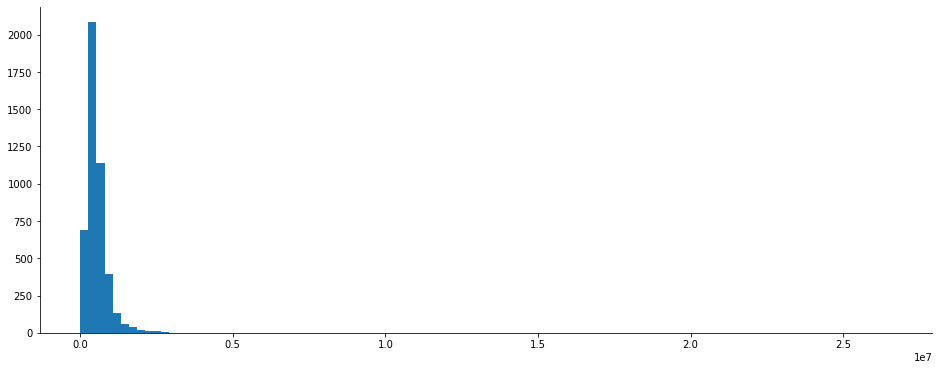

In [21]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 6)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

plt.hist(df['price'], bins=100);

Outliers are definitely present, so let’s handle them next.

we can calculate the Z-score with Scipy.

You’ll assign them as a new dataset column — **price_z**, and then keep only the rows in which the absolute value of Z is less than or equal to three

There are also some houses listed for $0, so we’ll delete those as well:


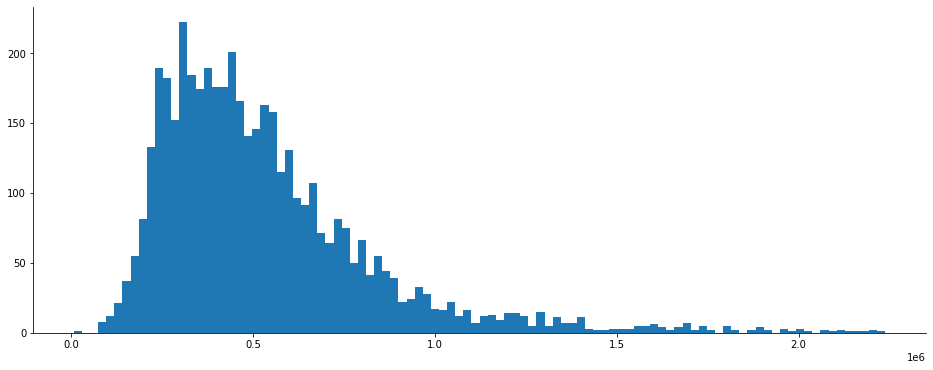

In [22]:
from scipy import stats

# Calculate Z-values
df['price_z'] = np.abs(stats.zscore(df['price']))

# Filter out outliers
df = df[df['price_z'] <= 3]

# Remove houses listed for $0
df = df[df['price'] != 0]

# Drop the column
df = df.drop('price_z', axis=1)

# Draw a histogram
plt.hist(df['price'], bins=100);

This declare look's good enough.

Here’s how the dataset looks now:

In [23]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,city,house_age,was_renovated,was_renovated_10_yrs,was_renovated_30_yrs
0,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,Shoreline,66,1,0,1
2,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,Kent,55,0,0,0
3,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,Bellevue,58,0,0,0
4,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,Redmond,45,1,0,1
5,490000.0,2.0,1.00,880,6380,1.0,0,0,3,880,0,Seattle,83,1,0,1


Let's see the information about the dataset

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4517 entries, 0 to 4599
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 4517 non-null   float64
 1   bedrooms              4517 non-null   float64
 2   bathrooms             4517 non-null   float64
 3   sqft_living           4517 non-null   int64  
 4   sqft_lot              4517 non-null   int64  
 5   floors                4517 non-null   float64
 6   waterfront            4517 non-null   int64  
 7   view                  4517 non-null   int64  
 8   condition             4517 non-null   int64  
 9   sqft_above            4517 non-null   int64  
 10  sqft_basement         4517 non-null   int64  
 11  city                  4517 non-null   object 
 12  house_age             4517 non-null   int64  
 13  was_renovated         4517 non-null   int64  
 14  was_renovated_10_yrs  4517 non-null   int64  
 15  was_renovated_30_yrs 

How many sample we have

In [25]:
len(df)

4517

**NOTE:** we have a small data (4517) sample so we expect that our prediction won't be so great because we have a small data set.

## Prepare our data ML

Shuffleing the datafram

In [26]:
data_df_shuffled = df.sample(frac=1, random_state=42)
data_df_shuffled.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,city,house_age,was_renovated,was_renovated_10_yrs,was_renovated_30_yrs
1574,445000.0,4.0,1.75,1990,4725,1.5,0,0,4,1190,800,Seattle,77,0,0,0
1425,630000.0,4.0,2.50,2740,43101,2.0,0,0,3,2740,0,Woodinville,28,0,0,0
4030,1450000.0,4.0,3.25,3770,4103,2.0,0,0,5,2710,1060,Seattle,96,0,0,0
1079,330000.0,3.0,1.00,1250,9126,1.0,0,0,3,1250,0,Woodinville,52,1,0,1
3257,350000.0,2.0,1.00,740,7680,1.0,0,0,4,740,0,Seattle,99,0,0,0


A neural network likes to see only numerical data on the same scale. 

Our dataset isn’t, and we also have some non-numerical data. 

That’s where data scaling and one-hot encoding come into play.

TO do this we can borrow a few classes from Scikit-learn.



In [27]:
# let's try one-hot encose our data so it all numbers
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [32]:
# Create a column transformer
ct = make_column_transformer(
    (MinMaxScaler(), ['sqft_living', 'sqft_lot','sqft_above', 
         'sqft_basement', 'house_age']),
    (OneHotEncoder(handle_unknown="ignore"), ['bedrooms', 'bathrooms', 'floors', 
         'view', 'condition'])
)

# Create X & y
X = data_df_shuffled.drop("price", axis=1)
y = data_df_shuffled["price"]

# Bulid our train and validation sets
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the column transformer to our training data
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScaler) and oneHotEncoder
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

In [33]:
# what does our data look like now?
X_train_normal[0]

<1x53 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

TensorFlow won’t be able to read that format, so we’ll have to convert it to a multidimensional Numpy array. 

We can use the toarray() function. Here’s an example:

In [37]:
X_train = X_train_normal.toarray()
X_test = X_test_normal.toarray()

In [40]:
# What does our data look like now?
X_train[0]

array([1.23741007e-01, 5.58877773e-04, 1.02158273e-01, 5.26315789e-02,
       4.38596491e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

Let’s finally train the model.

## Training a regression model with TensorFlow

We’ll now build a sequential model made of fully connected layers

### Loss tracking

We’re dealing with housing prices here, so the loss could be quite huge if we track it through.

let’s say, **mean squared error**.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):

* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecastes (y_pred) compare against the actual values (y_true or ground truth values)?**



In [62]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [69]:
# Create a function to take in model prediction and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

# Account fpr different sized metrics (for longer horizons, we want to reduce metrivs to a single value)
  if mae.ndim > 0:
    mae=tf.reduce_mean(mae)
    mse=tf.reduce_mean(mse)
    rmse=tf.reduce_mean(rmse)
    mape=tf.reduce_mean(mape)
    mase=tf.reduce_mean(mase)


  return {"MAE": mae.numpy(),
          "MSE": mse.numpy(),
          "RMSE": rmse.numpy(),
          "MAPE": mape.numpy(),
          "MASE": mase.numpy()}

That's one good looking evaluation function!

### Building a model

Now we you can finally declare a model.

It will be a simple one, having just three hidden layers of 256, 256, and 128 units.

then we'll compile the model using the `MAE` as a way to keep track of the loss and as an evaluation metric, and we’ll optimize the model using the Adam optimizer.

Finally, we’ll train the model on the training data for 100 epochs.

In [70]:
from tensorflow.keras import layers

In [71]:
# Set the random seed
tf.random.set_seed(42)

# Create model
model = tf.keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(1)
])

# Compile the model
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model.fit(X_train,
          y_train,
          epochs=100)

Epoch 1/100
113/113 [==============================] - 1s 3ms/step - loss: 524837.9375
Epoch 2/100
113/113 [==============================] - 0s 3ms/step - loss: 328637.7500
Epoch 3/100
113/113 [==============================] - 0s 3ms/step - loss: 186403.7969
Epoch 4/100
113/113 [==============================] - 0s 3ms/step - loss: 175402.7188
Epoch 5/100
113/113 [==============================] - 0s 3ms/step - loss: 169194.4062
Epoch 6/100
113/113 [==============================] - 0s 3ms/step - loss: 165066.6250
Epoch 7/100
113/113 [==============================] - 0s 3ms/step - loss: 161941.4531
Epoch 8/100
113/113 [==============================] - 0s 3ms/step - loss: 159442.5781
Epoch 9/100
113/113 [==============================] - 0s 3ms/step - loss: 157543.5938
Epoch 10/100
113/113 [==============================] - 0s 3ms/step - loss: 155999.4844
Epoch 11/100
113/113 [==============================] - 0s 3ms/step - loss: 154504.1875
Epoch 12/100
113/113 [===================

### Evaluate The model

In [72]:
model.evaluate(X_test, y_test)

29/29 [==============================] - 0s 2ms/step - loss: 146093.9062


146093.90625

### Making predictions

we can makw predictions on the test set:

In [73]:
predictions = model.predict(X_test)
predictions[:5]

29/29 [==============================] - 0s 1ms/step


array([[ 506876.3 ],
       [ 591096.1 ],
       [ 356052.75],
       [1217084.6 ],
       [ 736939.06]], dtype=float32)

### Model evaluation

And now let’s evaluate the predictions on the test set by using `evaluate_preds` function:

In [74]:
model_results =  evaluate_preds(y_true=y_test,
                                  y_pred=predictions)
model_results

{'MAE': 286039.3,
 'MSE': 157037660000.0,
 'RMSE': 385318.16,
 'MAPE': 63.982124,
 'MASE': 0.8825782}

The RMSE value on the training set is just above 385000, which means that for an average house, the model is wrong in the price estimate by $38500.

**Note:** we have expected that our model will predict the prices poorly because we have small dataset.

## Summary

And that does it — we’ve trained a simple neural network model by now, and you know how to make predictions on the new data. Still, there’s a lot we could improve.

For example, we could spend much more time preparing the data.

We deleted the date-time feature, the street information, the zip code and so on, which could be valuable for the model performance. 

The thing is — those would take too much time to prepare, and I want to keep these project somewhat short.

We could also add additional layers to the network, increase the number of neurons, choose different activation functions, select a different optimizer, add dropout layers, and much more.

The possibilities are almost endless, so it all boils down to experimentation.

